1/1 [==============================] - 0s 107ms/step
[0.4408684]
6
1 day input [0.89739697 1.         0.85165576 0.82129206 0.44086841]
1 day output [[0.43681806]]
2 day input [1.         0.85165576 0.82129206 0.44086841 0.43681806]
2 day output [[0.4185132]]
3 day input [0.85165576 0.82129206 0.44086841 0.43681806 0.41851321]
3 day output [[0.38626093]]
4 day input [0.82129206 0.44086841 0.43681806 0.41851321 0.38626093]
4 day output [[0.35909203]]


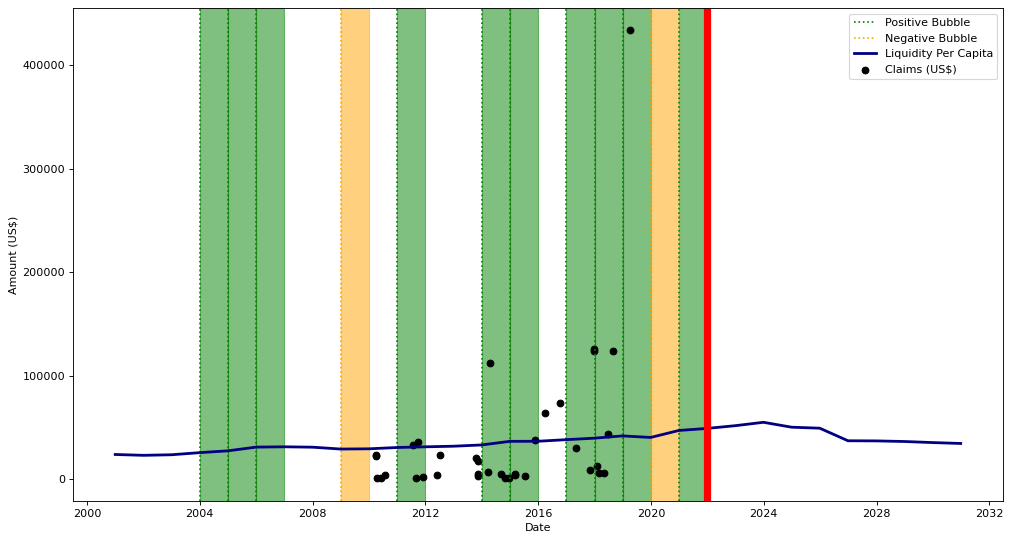

0.6388888888888888

In [315]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fredapi import Fred
import datetime
import pandas_datareader as pdr
import keras

from pandas_datareader.data import DataReader
from matplotlib.pyplot import figure

import math
import tensorflow
from keras import layers
from IPython.display import Image
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.impute import KNNImputer
%matplotlib inline

codes = pd.DataFrame(pd.read_excel(r"C:\Users\abhunia\OneDrive - Great American Insurance Group\Desktop\County_codes.xlsx"))

state_name = "Alabama" #Mention State Parameter
county_name = "Baldwin County" #Mention County Parameter

state_data = codes.loc[codes["State_name"] == state_name]

y = np.array(state_data["Per_capita_Personal_income"])[list(np.array(state_data["County_name"])).index(county_name)] #input parameter for Local GDP
w = np.array(state_data["Unemployment_rate"])[list(np.array(state_data["County_name"])).index(county_name)] #input parameter for local unemployment rates
z = np.array(state_data["FIPS_Code"])[list(np.array(state_data["County_name"])).index(county_name)]  #input parameter for debt-to-income ratio
tol_rate = 0.02 #Should not be negative, currently at 200 basis points

#Put the debt to income ratio link: 
data1=pd.DataFrame(pd.read_excel(r"C:\Users\abhunia\OneDrive - Great American Insurance Group\Desktop\debt_by_county.xlsx"))
imputer = KNNImputer(n_neighbors=6)
data1 = imputer.fit_transform(data1)
data1 = pd.DataFrame(data1)
data1=data1.rename(columns={0:"Year",1: "qtr",2:"area_fips",3:"low",4:"high"})
data1 = data1.astype({"Year":"int","qtr":"int","area_fips":"int"})
data1 = data1.set_index("Year") 
#data_querying
#debt to income ratio
fips_code = z
indexes = np.where(np.array(data1["area_fips"] == fips_code))[0]
data1 = data1.iloc[indexes]
data1 = data1[["area_fips","high"]]
data1 = data1[2:]
data1 = data1[:len(data1)-1] #prepped debt to income ratio

#Unemployment Data (FRED)
start = datetime.datetime(2001,1,1)
end = datetime.datetime.now()

data2 = pdr.DataReader(w, "fred", start=start, end=end)
a= len(data2)
b=1+len(data2)/12
b=int(b)

jax = np.linspace(0,a,b)
jax = jax[:len(jax)-1]

data2 = data2.iloc[jax]
data2 = data2[:len(data2)-1]

#GDP Data (FRED)
data3 = pdr.DataReader(y,"fred",start=start,end=end)

#Liquidity Calculation

d2i_ratio = np.array(data1["high"])
unemployment_percent = np.array(data2[w])/100
per_capita_income = np.array(data3[y])
loan_30yr_pay = (d2i_ratio*per_capita_income)/30

liquidity = (per_capita_income - loan_30yr_pay)*(1-unemployment_percent) + (-loan_30yr_pay)*unemployment_percent
first=pd.DataFrame(liquidity)
second=pd.DataFrame(data2.index)
liquidity_df=pd.concat([first,second],axis=1).set_index("DATE")




#-----------------------------------------------------------------------------Algorithm----------------------------------------------------------------
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.optimizers import Adam

#Geometric Brownian Motion (GBM) Component
a = pd.DataFrame(np.array(data1.index).astype(int)).rename(columns={0:"Year"})
b = pd.DataFrame(liquidity).rename(columns={0:"Liquidity"})
liq_df=pd.concat([a,b],axis =1).set_index("Year")
T = 1.        #time interval
N = 6       #number of points
seed = 20

d = T / N                 #time step
t = np.arange(0.0, 1.0, d)

def BrownianMotion(seed, N):
    np.random.seed(seed)
    Z = np.random.randn(N)     #random variables
    Z[0] = 0
    dW = np.sqrt(d)* Z        #single Brownian increment
    W = np.cumsum(dW)          #Brownian path
    
    return W

data_returns=liq_df["Liquidity"].pct_change()
data_returns=data_returns.dropna()

#compute the drift(mean) and diffusion(variance) coefficients and annualize it by multiplying by 5
mu = data_returns.mean() * N    
sig = data_returns.std()* np.sqrt(N)


#Constructing GBM

# Parameters:
# So - initial value 
# mu - the mean of returns 
# sigma - standard deviation of returns (volatility) 
# W - Brownian motion/stochastic part
# T - time horizon
# N - number of intervals
# We are using equation (4)

#find the Stochastic Differential Equation formula here: https://en.wikipedia.org/wiki/Geometric_Brownian_motion

def GBM_Exact(So, mu, sigma, W, N, t):
    
    S = []
    S.append(So)
          
    for i in range(1,N):
        drift = (mu - 0.5 * sigma**2) *t[i]       #Calculating the deterministic part
        diffusion = sigma * W[i-1]                #Calculating the stochastic part
        S_i = So * np.exp(drift + diffusion)
        S.append(S_i)
        
    return S

So = liq_df[len(liq_df)-1:len(liq_df)]
mu = mu
sigma = sig
W = BrownianMotion(seed, N)
N = N    
T = 1.0        

t = np.linspace(0., T, N)    #time increments

solution = GBM_Exact(So, mu, sig, W, N, t)
solution=np.reshape(solution,(N,1))
solution=pd.DataFrame(solution)
solution=solution.rename(columns={0: "Liquidity"})
solution = solution[1:]

brown_data = pd.concat([pd.DataFrame(np.arange(2001,np.array(data1.index).astype(int)[len(np.array(data1.index).astype(int))-1:len(np.array(data1.index).astype(int))]+N)).rename(columns={0:"Year"}),
          pd.DataFrame(np.concatenate([np.array(liq_df["Liquidity"]),np.array(solution["Liquidity"])])).rename(columns={0:"Liquidity"})],axis=1).set_index("Year")

#LSTM COMPONENT!
#Constructing a train,test split on the data
#Scaling the data/normalization of data
scaler=MinMaxScaler(feature_range=(0,1))
data_transform=scaler.fit_transform(np.array(brown_data).reshape(-1,1))

training_size=int(len(data_transform)*0.65)
test_size=len(data_transform)-training_size
train,test=data_transform[0:training_size,:],data_transform[training_size:len(data_transform),:1]
training_size,test_size

def create_dataset(dataset,time_step):
    dataX,dataY=[], []
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]  ###i=0, 0,1,2,3...29
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

time_step=5
X_train,y_train = create_dataset(train,time_step)
X_test,y_test= create_dataset(test,time_step)

X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)
#Layering Process
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=512, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=1024))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer="adam", loss='mean_squared_error')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=0)

#Prediction values at pre-performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

#Inverse transformation
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

x_input=test[int(len(test)-time_step):].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

# demonstrate prediction for next day
from numpy import array

lst_output=[]
n_steps=time_step
i=0
while(i<5):
    
    if(len(temp_input)>time_step):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    
day_new=np.arange(1,11)
day_pred=np.arange(11,16)

data2=data_transform.tolist()
data2.extend(lst_output)
data2=scaler.inverse_transform(data2).tolist()

actual_pred=day_pred,scaler.inverse_transform(lst_output)
data_pd=pd.DataFrame(actual_pred)

#write code: final_data to see the entire predicted values of the time series
#DATA PROCESSING COMPONENT!
data_pred=data_pd.transpose()
data_pred.columns=["Index","Liquidity"]
data_pred.drop(["Index"],axis=1,inplace=True)
data_pred['Liquidity'] =  data_pred['Liquidity'].str.get(0)
data_pred=pd.DataFrame(data_pred['Liquidity'])

data_pred["Year"]=pd.DataFrame(np.arange(int(np.array(brown_data.index.tolist())[-1:])+1,int(np.array(brown_data.index.tolist())[-1:])+len(data_pred)+1)).rename(columns={0:"Year"})
data_pred= data_pred.set_index("Year")
final_data = pd.concat([brown_data, data_pred],    # Combine vertically
                          ignore_index = False,
                          sort = False)

time_pd=pd.DataFrame(pd.date_range(start=liquidity_df.index[0],
                  end=datetime.timedelta((len(final_data)-1)*365)+liquidity_df.index[0],
                  periods=len(final_data))).rename(columns={0:"Year"})

liq_df = pd.DataFrame(np.array(final_data["Liquidity"])).rename(columns = {0:"Amount (US$)"})
true_data = pd.concat([time_pd,liq_df],axis=1).set_index("Year")

#---------------------------------------------------------------------------End Algorithm--------------------------------------------------------------




#Claims Data Prep

claims_data= pd.DataFrame(pd.read_excel(r"C:\Users\abhunia\OneDrive - Great American Insurance Group\Desktop\Data_claims.xlsx"))
county_fips_code = z #input parameter

indexes2 = np.where(np.array(claims_data["CHOSEN_COUNTY_FIPS"] == county_fips_code))[0]

cl_df=claims_data.iloc[indexes2]
cl_df1=cl_df[["RPT_DATE","LOB","TOTAL_INCURRED"]]


#natural growth rate

natural_growth_rate = np.mean(np.array(data3[y].pct_change().dropna()))
nat1 = natural_growth_rate*(1+tol_rate)
nat2 = natural_growth_rate*(1-tol_rate)
df1 = np.array(pd.DataFrame(liquidity).pct_change().dropna()).reshape((len(np.array(pd.DataFrame(liquidity).pct_change().dropna()))))


#Positive Bubble

a = df1 > nat1
pos_points = np.where(a == True)[0]+1
pos_points = pos_points.astype(np.int32)

#Negative Bubble

b = -nat2 > df1
neg_points = np.where(b == True)[0]+1
neg_points = neg_points.astype(np.int32)

#Plotting the Graph
figure(figsize=(15,8),dpi=80)

list1 = []

for i in pos_points:
    pos_date_vals = np.array(data3[y].index)[i]
    list1.append(pos_date_vals)
    
list3 = []

for i in pos_points:
    pos_date_vals = np.array(data3[y].index)[i]
    list3.append(pos_date_vals)

list4 = []

for j in neg_points:
    neg_date_vals =  np.array(data3[y].index)[j]
    list4.append(neg_date_vals)
    
my_label1="Positive Bubble"

for xd in list3:
    plt.axvline(x=xd,color = "green", linestyle = ":",label = my_label1)
    my_label2 = "_nolegend_"
    
my_label2= "Negative Bubble"

for xu in list4:
    plt.axvline(x=xu,color = "orange", linestyle = ":",label = my_label2)
    my_label2 = "_nolegend_"

ga = pd.DatetimeIndex(list3)
ga1 = pd.DatetimeIndex(list3) + datetime.timedelta(365)

ha = pd.DatetimeIndex(list4)
ha1 = pd.DatetimeIndex(list4) + datetime.timedelta(365)

for i in np.arange(0,len(list3)):
    plt.axvspan(ga[i],ga1[i],alpha = 0.5, color = "green")

for j in np.arange(0,len(list4)):
    plt.axvspan(ha[j],ha1[j], alpha = 0.5, color = "orange")
    
plt.plot(true_data,color = "navy", label="Liquidity Per Capita", linewidth =2.5)
plt.scatter(cl_df1["RPT_DATE"],cl_df1["TOTAL_INCURRED"],color="black", label="Claims (US$)")
plt.axvline(x=true_data.index[21],color = 'red',linewidth = 6.5)

plt.xlabel("Date")
plt.ylabel("Amount (US$)")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

# Accuracy Calculation

one = []

for i in cl_df1["RPT_DATE"]:
    one.append(i)

two = []
for i in list(np.arange(0,len(one))):
    two.append(one[i].year)


three = []
for i in np.arange(0,len(ga)):
    ga1=ga[i]
    three.append(ga1)

four = []
for i in list(np.arange(0,len(three))):
    four.append(three[i].year)

five = []
for i in np.arange(0,len(ha)):
    ha1 = ha[i]
    five.append(ha)
    
six = []
for i in list(np.arange(0,len(five))):
    six.append(five[i].year)

    
two = np.array(two)
four = np.array(four)
six = np.array(six)

count = 0
for i in two:
    if i in four:
        count +=1
    elif i in six:
        count +=1
  

col1 = liquidity_df.rename(columns = {0:"Liquidity"})
col1["Debt_to_Income_ratio"] = d2i_ratio
col1["Per_capita_disposable_income"] = per_capita_income
col1["Annual_loan_payment"] = loan_30yr_pay
col1["Unemployment"] = unemployment_percent
cl_df1.set_index("RPT_DATE")

with pd.ExcelWriter('DIRB_REPORT.xlsx') as writer:
    col1.to_excel(writer, sheet_name='Model Summary')
    cl_df1.to_excel(writer, sheet_name='High Severity Claims Report')

    #Accuracy Rates

accuracy = count/len(one)
accuracy

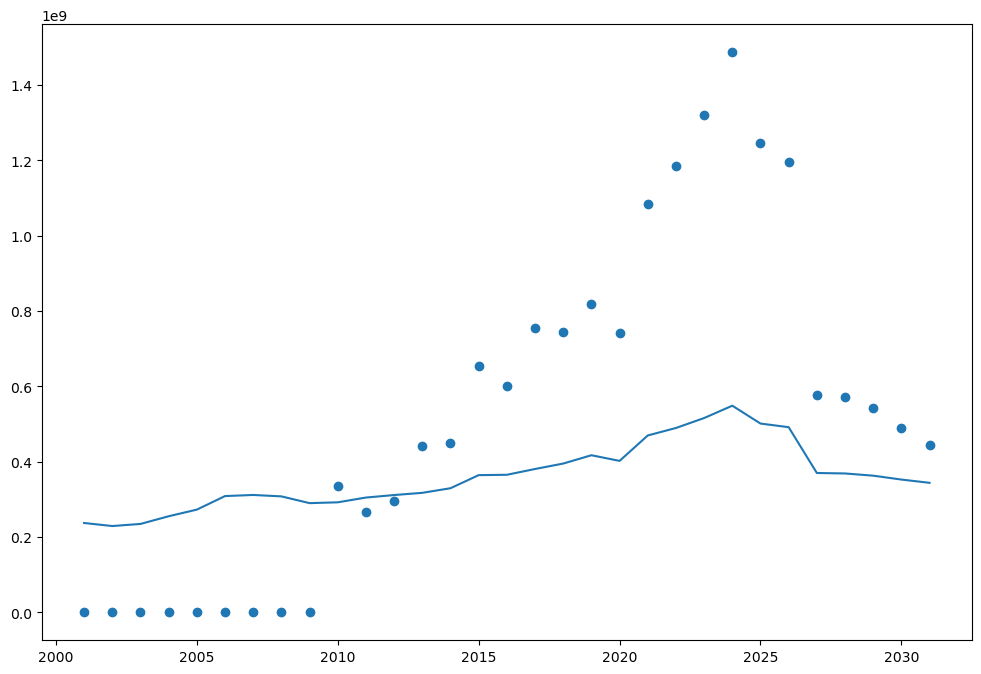

In [316]:
listr = []
for i in np.arange(2010,np.amax([claims_data[["AX_YR"]]])+1):
    vals = np.array(claims_data[["TOTAL_INCURRED"]])[np.where(claims_data[["AX_YR"]] == i)[0]]
    listr.append(vals.sum())

incur=pd.DataFrame(np.array(listr)).rename(columns={0:"TOTAL_INCURRED"})


incur_data = pd.concat([pd.DataFrame(np.zeros(9)).rename(columns={0:"TOTAL_INCURRED"}), incur],    # Combine vertically
                          ignore_index = True,
                          sort = False)

incur_data["Year"] = pd.DataFrame(final_data[:18].index)
incur_data=incur_data.set_index("Year")
reg_data = pd.concat([final_data[:18],incur_data],ignore_index =False,axis=1)

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

X = np.array(reg_data["Liquidity"])
y = np.array(reg_data["TOTAL_INCURRED"])

def linreg(X,y):
    model1 = LinearRegression()
    model1.fit(np.array(X).reshape(-1,1),np.array(y))
    y_pred = model1.predict(np.array(X).reshape(-1,1))
    rsquare_linregmetrics=np.average(1-((np.array(y)-y_pred)**2)/((np.array(y)-np.average(np.array(y)))**2))
    
    return rsquare_linregmetrics

def glmreg(X,y):
    X = sm.add_constant(np.array(X))
    model2 = sm.GLM(y, X, family=sm.families.Gaussian())
    results = model2.fit()
    rsquare_glmmetrics=results.pseudo_rsquared(kind='cs')
    
    return rsquare_glmmetrics

first = pd.DataFrame(model1.intercept_+np.array(final_data["Liquidity"])*model1.coef_).rename(columns={0:"TOTAL_INCURRED"})
second = pd.DataFrame(pd.DataFrame(np.array(final_data["Liquidity"])).rename(columns = {0:"Liquidity"}))
index = pd.DataFrame(final_data.index)

proj_data = pd.concat([second,first,index],axis=1).set_index("Year")
proj_data =pd.concat([reg_data,proj_data[18:]])

fig = plt.figure(figsize=(12,8))
plt.plot(proj_data["Liquidity"]*1e4)
plt.scatter(proj_data.index,proj_data["TOTAL_INCURRED"])